In [1127]:
from gurobipy import *
import numpy as np

'''
A gardener wants to maximize the height of the stem of a tulip she plants after 3 months.
She needs to decide (tulip_type) between buying two different types of tulips:
    1. Red Tulip (Tulipa orphanidea, tulip_type = 1): Average height is 15cm, std dev is 5cm
    2. Purple Tulip (Tulipa saxatilis, tulip_type = 0): Average height is 15cm, std dev is 10cm
Additionally, she will decide how many mL of water/week (water) to give the tulip (250mL-1L)
    1. For the red tulip, more water increases the average height by a factor of 0.0012*water
       and increases the std dev by a factor of 0.01*water
    2. For the purple tulip, more water increases the height by a factor of 0.001*water and
       and decreases the std dev by a factor of 0.005*water
This gardener is on a budget because her tution is $17K this year. She does not want to spend
more than $12 in 3 months.
    $1.5*tulip_type + $1.0*(1 - tulip_type) + $0.012*water <= $12 
'''
# Create model 
model1 = Model("Model #1")
model1.setParam('OutputFlag', 0)

# Create Variables 
tulip_type = model1.addVar(vtype = GRB.BINARY, name = "Tulip Type")
water = model1.addVar(lb = 250, ub = 1000, name = "Amount of Water/week (mL)")
avg = model1.addVar(name = "Average")
stdev = model1.addVar(name = "Standard Deviation")

# Monte Carlo-ing Expectation
n = 1000
i = 0
navg = 0 # For testing
norms = np.random.standard_normal(n)
#obj = LinExpr()
#obj = avg + stdev*np.random.standard_normal(n)
'''
while i < n:
    norm = np.random.standard_normal()
    navg += norm
    obj += avg + stdev*norm
    i += 1
print("Standard normal sample average: " + str(navg/n))
'''
# Set objective
model1.setObjective((1/n)*(sum(avg + stdev*norm for norm in norms)), GRB.MAXIMIZE)

# Set constraints 
M = 1000

# If tulip_type = 1, avg = 15 + 0.001*water, else avg = 15 + 0.001*water
model1.addConstr(avg <= 15 + 0.0011*water + M*(1 - tulip_type))
model1.addConstr(avg >= 15 + 0.0011*water - M*(1 - tulip_type))
model1.addConstr(avg <= 15 + 0.001*water + M*tulip_type)
model1.addConstr(avg >= 15 + 0.001*water - M*tulip_type)

# If tulip_type = 1, stdev = 5 + 0.01*water, else avg = 10 - 0.01*water
model1.addConstr(stdev <= 5 - 0.001*water + M*(1 - tulip_type))
model1.addConstr(stdev >= 5 - 0.001*water - M*(1 - tulip_type))
model1.addConstr(stdev <= 10 - 0.005*water + M*tulip_type)
model1.addConstr(stdev >= 10 - 0.005*water - M*tulip_type)

#Budget Constraint
model1.addConstr(1.5*tulip_type + 1.0*(1 - tulip_type) + 0.015*water <= 12)

# Optimize model
model1.optimize()

# Print results 
for v in model1.getVars():
    print('%s: %g' % (v.varName, v.x))

print('Stem Height: %g' % model1.objVal)


Tulip Type: 1
Amount of Water/week (mL): 700
Average: 15.77
Standard Deviation: 4.3
Stem Height: 15.7465


In [1114]:
from gurobipy import *
import numpy as np

'''
The gardener now decides she wants to maximize the sum of the heights of the stem and flower.
She adds whether to plant the tulip outside (d = 1) in a flower bed to her list of considerations.
* Note: planting the tulip outside always adds 1 to the std dev of any distribution 
  since the outdoors present more variability 
      (i.e flower can be eaten by an animal, or thrive because of rich soil etc.)
Additionally, she considers the positive proportional relationship between total leaf surface area (lsa) 
and stem height:
    Stem Height ~ N(0.1*lsa, 0.05*lsa)
Each tulip type's leaf surface area and flower height are normally distributed and are affected by amount of water
and whether or not the plant is outside or not.         
    lsa ~ N(100 + 0.06*x + 5*d, 100 + 0.01*x + d) (if t = 1, total leaf SA ranges from 80-230cm^2)
    lsa ~ N(145 + 0.01*x + 5*d, 33 - 0.005*x + d) (if t = 0, total leaf SA ranges from 120-185cm^2)
       - More water increases lsa because there is more water available for photosynthesis 
         (photosynthesis occurs in the leaves)
       - Being planted outdoors increases lsa because there is more competition which causes 
         the plant to direct more growth to the leaf to be able to get more sunlight     
    Flower Height ~ N(3 - 0.001*x + 1.5*(1 - d), 1.35 + d) (if t = 1, petal height is 2-4.7cm)
                  ~ N(3 - 0.0015*x + 0.5*(1 - d), 0.75 + d) (if t = 0, petal height is 2-3.5cm)
        - In drought conditions, plants direct more growth to their reproductive organ (flower)
          than leaf growth because larger lsa increases water loss and to ensure the species remains
          in the area (via reproduction) should it die during a drought. Simulate drought conditions 
          (less water) to induce flower growth
        - Being indoors increases flower height because there is less competition so the plant doesn't
          have to direct most growth to leaf surface area 
Regarding the budget, if she decides to plant the tulip indoors, she must buy a planter for $2.
'''
j = 0
while j < 100: 
    # Create model 
    model2 = Model("Model #2")
    model2.setParam('OutputFlag', 0)

    # Create Variables 
    tulip_type = model2.addVar(vtype = GRB.BINARY, name = "Tulip Type")
    water = model2.addVar(lb = 250, ub = 1000, name = "Amount of Water/week (mL)")
    outdoor = model2.addVar(vtype = GRB.BINARY, name = "Outdoor?")
    lsaavg = model2.addVar(name = "Total Leaf Surface Area Average")
    lsastdev = model2.addVar(name = "Total Leaf Surface Area Standard Deviation")
    lsa = model2.addVar(name = "Total Leaf Surface Area")
    flavg = model2.addVar(name = "Flower Petal Height Average")
    flstdev = model2.addVar(name = "Flower Petal Height Standard Deviation")

    # Monte Carlo-ing Expectation
    n = 10000
    i = 0
    # Store sample averages for testing 
    lavg = 0
    savg = 0
    favg = 0
    leaf = LinExpr()
    stem = LinExpr()
    flower = LinExpr()
    while i < n:
        lnorm = np.random.standard_normal()
        snorm = np.random.standard_normal()
        fnorm = np.random.standard_normal()

        leaf += lsaavg + lsastdev*lnorm
        stem += 0.1*(lsa) + 0.05*(lsa)*snorm
        flower += flavg + flstdev*fnorm 

        lavg += lnorm
        savg += snorm 
        favg += fnorm

        i += 1

    lavg = (1/n)*lavg
    savg = (1/n)*savg
    favg = (1/n)*favg

    print("Leaf standard normal sample average: " + str(lavg))
    print("Stem standard normal sample average: " + str(savg))
    print("Flower standard normal sample average: " + str(favg) + "\n")

    # Set objective
    model2.setObjective((1/n)*(stem + flower), GRB.MAXIMIZE)

    # Set constraints 
    M = 10000

    # Leaf Constraints
    # If tulip_type = 1, lsaavg = 100 + 0.06*water + 5*outdoor, 
    # else lsaavg = 145 + 0.01*water + 5*outdoor
    model2.addConstr(lsaavg <= 131 + 0.05*water + 20*outdoor + M*(1 - tulip_type))
    model2.addConstr(lsaavg >= 131 + 0.05*water + 20*outdoor - M*(1 - tulip_type))
    model2.addConstr(lsaavg <= 150 + 0.005*water + 5*outdoor + M*tulip_type)
    model2.addConstr(lsaavg >= 150 + 0.005*water + 5*outdoor - M*tulip_type)
    # If tulip_type = 1, lsastdev = 100 + 0.01*water + outdoor, 
    # else lsastdev = 33 - 0.005*water + outdoor
    model2.addConstr(lsastdev <=  65 - 0.001*water + outdoor + M*(1 - tulip_type))
    model2.addConstr(lsastdev >=  65 - 0.001*water + outdoor - M*(1 - tulip_type))
    model2.addConstr(lsastdev <=  30 - 0.005*water + outdoor + M*tulip_type)
    model2.addConstr(lsastdev >= 30 - 0.005*water + outdoor - M*tulip_type)
    # Setting lsa = leaf expression 
    model2.addConstr(lsa <= (1/n)*leaf)
    model2.addConstr(lsa >= (1/n)*leaf)

    # Flower Constraints 
    # If tulip_type= 1, flavg = 3 - 0.001*water + 1.5*(1 - outdoor), 
    # else flavg = 3 - 0.0015*water + 0.5*(1 - outdoor)
    model2.addConstr(flavg <= 6 - 0.001*water + 2.0*(1 - outdoor) + M*(1 - tulip_type))
    model2.addConstr(flavg >= 6 - 0.001*water + 2.0*(1 - outdoor) - M*(1 - tulip_type))
    model2.addConstr(flavg <= 8 - 0.0015*water + 1.0*(1 - outdoor) + M*tulip_type)
    model2.addConstr(flavg >= 8 - 0.0015*water + 1.0*(1 - outdoor) - M*tulip_type)
    # If tulip_type = 1, flstdev = 1.35 + outdoor, else flstdev = 0.75 + outdoor
    model2.addConstr(flstdev <= 1.35 + outdoor + M*(1 - tulip_type))
    model2.addConstr(flstdev >= 1.35 + outdoor - M*(1 - tulip_type))
    model2.addConstr(flstdev <= 0.75 + outdoor + M*tulip_type)
    model2.addConstr(flstdev >= 0.75 + outdoor - M*tulip_type)

    # Budget Constraint 
    model2.addConstr(1.5*tulip_type + 1.0*(1 - tulip_type) + 0.015*water + 2*(1 - outdoor) <= 12)

    # Optimize model
    model2.optimize()

    # Print and check results
    checkLA = 100*tulip_type.x + 0.05*water.x*tulip_type.x + 5*outdoor.x*tulip_type.x + 145*(1-tulip_type.x) + 0.01*water.x*(1-tulip_type.x) + 5*outdoor.x*(1-tulip_type.x)
    checkLSD = 100*tulip_type.x + 0.01*water.x*tulip_type.x + outdoor.x*tulip_type.x + 33*(1-tulip_type.x) - 0.005*water.x*(1-tulip_type.x) + outdoor.x*(1-tulip_type.x)
    checkFA = 3*tulip_type.x - 0.001*water.x*tulip_type.x + 1.5*(1-outdoor.x)*tulip_type.x + 3*(1-tulip_type.x) - 0.0015*water.x*(1-tulip_type.x) + 0.5*(1-outdoor.x)*(1 - tulip_type.x)
    checkFSD = 1.35*tulip_type.x + outdoor.x*tulip_type.x + 0.75*(1-tulip_type.x) + outdoor.x*(1-tulip_type.x)
    checkLeafSA = checkLA + checkLSD*lavg
    for v in model2.getVars():
        print('Gurobi Result: %s: %g' % (v.varName, v.x))
        if v.varName == "Total Leaf Surface Area Average":
            print('\tCheck Result: ' + str(checkLA))
        elif v.varName == 'Total Leaf Surface Area Standard Deviation':
            print('\tCheck Result: ' + str(checkLSD))
        elif v.varName == 'Total Leaf Surface Area':
            print('\tCheck Result: ' + str(checkLeafSA))
        elif v.varName == 'Flower Petal Height Average':
            print('\tCheck Result: ' + str(checkFA))
        elif v.varName == 'Flower Petal Height Standard Deviation':
            print('\tCheck Result: ' + str(checkFSD))


    print('\nGurobi Stem + Flower Height (obj): %g' % model2.objVal)
    print('\tCheck Stem Height: ' + str(0.1*checkLeafSA + 0.01*checkLeafSA*savg))
    print('\tCheck Flower Height: ' + str(checkFA + checkFSD*favg))
    print('\tCheck Total Height (obj): ' + str(0.1*checkLeafSA + 0.01*checkLeafSA*savg + checkFA + checkFSD*favg))
    j += 1

Leaf standard normal sample average: -0.0057915148048686745
Stem standard normal sample average: 0.001062890420661541
Flower standard normal sample average: 0.0002336954271496805

Gurobi Result: Tulip Type: 1
Gurobi Result: Amount of Water/week (mL): 700
Gurobi Result: Outdoor?: 1
Gurobi Result: Total Leaf Surface Area Average: 186
	Check Result: 140.00000000000014
Gurobi Result: Total Leaf Surface Area Standard Deviation: 65.3
	Check Result: 108.00000000000003
Gurobi Result: Total Leaf Surface Area: 185.622
	Check Result: 139.37451640107432
Gurobi Result: Flower Petal Height Average: 5.3
	Check Result: 2.299999999999997
Gurobi Result: Flower Petal Height Standard Deviation: 2.35
	Check Result: 2.35

Gurobi Stem + Flower Height (obj): 23.8726
	Check Stem Height: 13.938933038491104
	Check Flower Height: 2.300549184253799
	Check Total Height (obj): 16.239482222744904
Leaf standard normal sample average: 0.013297544114824826
Stem standard normal sample average: 0.004659520231925155
Flower

Leaf standard normal sample average: -0.005028797757767047
Stem standard normal sample average: -0.012254539328325703
Flower standard normal sample average: -0.0015772759973502538

Gurobi Result: Tulip Type: 1
Gurobi Result: Amount of Water/week (mL): 700
Gurobi Result: Outdoor?: 1
Gurobi Result: Total Leaf Surface Area Average: 186
	Check Result: 140.00000000000014
Gurobi Result: Total Leaf Surface Area Standard Deviation: 65.3
	Check Result: 108.00000000000003
Gurobi Result: Total Leaf Surface Area: 185.672
	Check Result: 139.4568898421613
Gurobi Result: Flower Petal Height Average: 5.3
	Check Result: 2.299999999999997
Gurobi Result: Flower Petal Height Standard Deviation: 2.35
	Check Result: 2.35

Gurobi Stem + Flower Height (obj): 23.7497
	Check Stem Height: 13.928599184804364
	Check Flower Height: 2.296293401406224
	Check Total Height (obj): 16.224892586210586
Leaf standard normal sample average: 0.014664211838416461
Stem standard normal sample average: -0.002850248812998193
Flowe

Leaf standard normal sample average: -0.001967194443812685
Stem standard normal sample average: -0.0034185022208841993
Flower standard normal sample average: 0.01923780919171888

Gurobi Result: Tulip Type: 1
Gurobi Result: Amount of Water/week (mL): 700
Gurobi Result: Outdoor?: 1
Gurobi Result: Total Leaf Surface Area Average: 186
	Check Result: 140.00000000000003
Gurobi Result: Total Leaf Surface Area Standard Deviation: 65.3
	Check Result: 108.0
Gurobi Result: Total Leaf Surface Area: 185.872
	Check Result: 139.78754300006827
Gurobi Result: Flower Petal Height Average: 5.3
	Check Result: 2.2999999999999994
Gurobi Result: Flower Petal Height Standard Deviation: 2.35
	Check Result: 2.35

Gurobi Stem + Flower Height (obj): 23.9006
	Check Stem Height: 13.97397565974485
	Check Flower Height: 2.345208851600539
	Check Total Height (obj): 16.319184511345387
Leaf standard normal sample average: 0.005264605582779601
Stem standard normal sample average: 0.005579187752919017
Flower standard norm

Leaf standard normal sample average: -0.004733770654188006
Stem standard normal sample average: 0.01688426210982861
Flower standard normal sample average: -0.009296541219002833

Gurobi Result: Tulip Type: 1
Gurobi Result: Amount of Water/week (mL): 700
Gurobi Result: Outdoor?: 1
Gurobi Result: Total Leaf Surface Area Average: 186
	Check Result: 139.9999999999999
Gurobi Result: Total Leaf Surface Area Standard Deviation: 65.3
	Check Result: 107.99999999999997
Gurobi Result: Total Leaf Surface Area: 185.691
	Check Result: 139.48875276934757
Gurobi Result: Flower Petal Height Average: 5.3
	Check Result: 2.3000000000000025
Gurobi Result: Flower Petal Height Standard Deviation: 2.35
	Check Result: 2.35

Gurobi Stem + Flower Height (obj): 24.004
	Check Stem Height: 13.972426923566065
	Check Flower Height: 2.278153128135346
	Check Total Height (obj): 16.25058005170141
Leaf standard normal sample average: -0.004301017361411196
Stem standard normal sample average: 0.007537504989788912
Flower st

Leaf standard normal sample average: 0.014132443302131098
Stem standard normal sample average: -0.0036748154462356193
Flower standard normal sample average: -0.01912633747104865

Gurobi Result: Tulip Type: 1
Gurobi Result: Amount of Water/week (mL): 700
Gurobi Result: Outdoor?: 1
Gurobi Result: Total Leaf Surface Area Average: 186
	Check Result: 139.9999999999999
Gurobi Result: Total Leaf Surface Area Standard Deviation: 65.3
	Check Result: 107.99999999999997
Gurobi Result: Total Leaf Surface Area: 186.923
	Check Result: 141.52630387663004
Gurobi Result: Flower Petal Height Average: 5.3
	Check Result: 2.3000000000000025
Gurobi Result: Flower Petal Height Standard Deviation: 2.35
	Check Result: 2.35

Gurobi Stem + Flower Height (obj): 23.913
	Check Stem Height: 14.14742955718766
	Check Flower Height: 2.255053106943038
	Check Total Height (obj): 16.402482664130698
Leaf standard normal sample average: 0.008250851251637945
Stem standard normal sample average: -0.004373646023749828
Flower s

Leaf standard normal sample average: 0.0038369546590971484
Stem standard normal sample average: -0.0006719411491588014
Flower standard normal sample average: 0.004575987207515545

Gurobi Result: Tulip Type: 1
Gurobi Result: Amount of Water/week (mL): 700
Gurobi Result: Outdoor?: 1
Gurobi Result: Total Leaf Surface Area Average: 186
	Check Result: 140.00000000000003
Gurobi Result: Total Leaf Surface Area Standard Deviation: 65.3
	Check Result: 108.0
Gurobi Result: Total Leaf Surface Area: 186.251
	Check Result: 140.4143911031825
Gurobi Result: Flower Petal Height Average: 5.3
	Check Result: 2.2999999999999994
Gurobi Result: Flower Petal Height Standard Deviation: 2.35
	Check Result: 2.35

Gurobi Stem + Flower Height (obj): 23.9296
	Check Stem Height: 14.040495608245088
	Check Flower Height: 2.310753569937661
	Check Total Height (obj): 16.35124917818275
Leaf standard normal sample average: -0.0020502593347071964
Stem standard normal sample average: -0.011245740216856986
Flower standard n

Leaf standard normal sample average: 0.01911347022422666
Stem standard normal sample average: -0.0030393385301114443
Flower standard normal sample average: 0.000932748544374987

Gurobi Result: Tulip Type: 1
Gurobi Result: Amount of Water/week (mL): 700
Gurobi Result: Outdoor?: 1
Gurobi Result: Total Leaf Surface Area Average: 186
	Check Result: 140.00000000000003
Gurobi Result: Total Leaf Surface Area Standard Deviation: 65.3
	Check Result: 108.0
Gurobi Result: Total Leaf Surface Area: 187.248
	Check Result: 142.0642547842165
Gurobi Result: Flower Petal Height Average: 5.3
	Check Result: 2.2999999999999994
Gurobi Result: Flower Petal Height Standard Deviation: 2.35
	Check Result: 2.35

Gurobi Stem + Flower Height (obj): 23.9985
	Check Stem Height: 14.202107664788478
	Check Flower Height: 2.3021919590792805
	Check Total Height (obj): 16.50429962386776
Leaf standard normal sample average: 0.01743275938885903
Stem standard normal sample average: 0.014200504978253828
Flower standard normal

Leaf standard normal sample average: -0.0014459880093745812
Stem standard normal sample average: 0.0008374127013725446
Flower standard normal sample average: 0.00760402243015456

Gurobi Result: Tulip Type: 1
Gurobi Result: Amount of Water/week (mL): 700
Gurobi Result: Outdoor?: 1
Gurobi Result: Total Leaf Surface Area Average: 186
	Check Result: 139.9999999999998
Gurobi Result: Total Leaf Surface Area Standard Deviation: 65.3
	Check Result: 107.99999999999996
Gurobi Result: Total Leaf Surface Area: 185.906
	Check Result: 139.84383329498735
Gurobi Result: Flower Petal Height Average: 5.3
	Check Result: 2.300000000000004
Gurobi Result: Flower Petal Height Standard Deviation: 2.35
	Check Result: 2.35

Gurobi Stem + Flower Height (obj): 23.9162
	Check Stem Height: 13.985554399520833
	Check Flower Height: 2.317869452710867
	Check Total Height (obj): 16.3034238522317
Leaf standard normal sample average: -0.004571161643923545
Stem standard normal sample average: 0.011100563464322402
Flower st

Leaf standard normal sample average: -0.00032960197372818733
Stem standard normal sample average: 0.011191773054638293
Flower standard normal sample average: -0.0030336969891606464

Gurobi Result: Tulip Type: 1
Gurobi Result: Amount of Water/week (mL): 700
Gurobi Result: Outdoor?: 1
Gurobi Result: Total Leaf Surface Area Average: 186
	Check Result: 139.9999999999999
Gurobi Result: Total Leaf Surface Area Standard Deviation: 65.3
	Check Result: 107.99999999999997
Gurobi Result: Total Leaf Surface Area: 185.978
	Check Result: 139.96440298683723
Gurobi Result: Flower Petal Height Average: 5.3
	Check Result: 2.3000000000000025
Gurobi Result: Flower Petal Height Standard Deviation: 2.35
	Check Result: 2.35

Gurobi Stem + Flower Height (obj): 23.9948
	Check Stem Height: 14.012104797023289
	Check Flower Height: 2.292870812075475
	Check Total Height (obj): 16.304975609098765
Leaf standard normal sample average: -0.014539678896601502
Stem standard normal sample average: -0.0025048171336943615
F

Leaf standard normal sample average: -0.001522057100867574
Stem standard normal sample average: -0.003763534417209484
Flower standard normal sample average: -0.0023924529551101535

Gurobi Result: Tulip Type: 1
Gurobi Result: Amount of Water/week (mL): 700
Gurobi Result: Outdoor?: 1
Gurobi Result: Total Leaf Surface Area Average: 186
	Check Result: 139.99999999999994
Gurobi Result: Total Leaf Surface Area Standard Deviation: 65.3
	Check Result: 107.99999999999999
Gurobi Result: Total Leaf Surface Area: 185.901
	Check Result: 139.83561783310626
Gurobi Result: Flower Petal Height Average: 5.3
	Check Result: 2.3000000000000016
Gurobi Result: Flower Petal Height Standard Deviation: 2.35
	Check Result: 2.35

Gurobi Stem + Flower Height (obj): 23.8495
	Check Stem Height: 13.978299021705961
	Check Flower Height: 2.294377735555493
	Check Total Height (obj): 16.272676757261454
Leaf standard normal sample average: 0.016671370292542315
Stem standard normal sample average: 0.00039158347434696533
Fl

In [1115]:
from gurobipy import *
import numpy as np

'''
Finally, the gardener decides she wants to maximize the sum of the heights of the stem and the flower 
as well as the length of the roots.
Since she is now taking the roots into consideration, she must also decide how many pellets (p) of fertilizer
to put into the soil/month (2 <= p <= 5). Each pellet costs $0.25 
The addition of fertilizer affects the leaf surface area (lsa) distribution:
   lsa ~ N(100 + 0.04*x + 5*d - 10*p, 100 + 0.01*x + d) (if t = 1)
   lsa ~ N(145 + 0.01*x + 5*d - 10*p, 33 - 0.005*x + d) (if t = 0)
       - The addition of too much fertilizer causes the edges of the leaves to shrivel due to
         a phenomenon called "fertilizer burn", where the water sent from the roots to the 
         leaves is oversaturated with nutrients which causes the leaf tissues to dry
       - To ensure the plant does not completely dry up, we must add a constraint that we must add at
         least 150*p mL of water 
The root length (cm) is normally distributed:
    Root length ~ N(20 + p + 2*d , 1 + d)
        - Planting the tulip outside can increase the root length because of there is more space available
          and more nutrients at deeper altitudes. 
The stem and flower distributions remain the same. 
'''
j = 0 
while j < 100:
    # Create Model
    model3 = Model("Model #3")
    model3.setParam('OutputFlag', 0)

    # Create Variables 
    tulip_type = model3.addVar(vtype = GRB.BINARY, name = "Tulip Type")
    water = model3.addVar(lb = 250, ub = 1000, name = "Amount of Water/week (mL)")
    outdoor = model3.addVar(vtype = GRB.BINARY, name = "Outdoor?")
    pellets = model3.addVar(lb = 2, ub = 5, vtype = GRB.INTEGER, name = "Number of Fertilizer Pellets")
    lsaavg = model3.addVar(name = "Total Leaf Surface Area Average")
    lsastdev = model3.addVar(name = "Total Leaf Surface Area Standard Deviation")
    lsa = model3.addVar(name = "Total Leaf Surface Area")
    flavg = model3.addVar(name = "Flower Petal Height Average")
    flstdev = model3.addVar(name = "Flower Petal Height Standard Deviation")
    roavg = model3.addVar(name = "Root Length Average")
    rostdev = model3.addVar(name = "Root Length Standard Deviation")

    # Monte Carlo-ing Expectation
    n = 10000
    i = 0
    lavg = 0
    savg = 0
    favg = 0
    ravg = 0
    leaf = LinExpr()
    stem = LinExpr()
    flower = LinExpr()
    roots = LinExpr()
    while i < n:
        lnorm = np.random.standard_normal()
        snorm = np.random.standard_normal()
        fnorm = np.random.standard_normal()
        rnorm = np.random.standard_normal()

        leaf += lsaavg + lsastdev*lnorm
        stem += 0.1*(lsa) + 0.05*(lsa)*snorm
        flower += flavg + flstdev*fnorm 
        roots += roavg + rostdev*rnorm 
        #roots += 20 + 1.01*pellets + 0.25*outdoor + (1 + outdoor)*rnorm

        lavg += lnorm
        savg += snorm 
        favg += fnorm
        ravg += rnorm

        i += 1

    lavg = (1/n)*lavg
    savg = (1/n)*savg
    favg = (1/n)*favg
    ravg = (1/n)*ravg

    print("Leaf standard normal sample average: " + str(lavg))
    print("Stem standard normal sample average: " + str(savg))
    print("Flower standard normal sample average: " + str(favg))
    print("Roots standard normal sample average: " + str(ravg) + "\n")

    # Set objective
    model3.setObjective((1/n)*(stem + flower + roots), GRB.MAXIMIZE)

    # Set constraints 
    M = 10000

    # Leaf Constraints
    # If tulip_type = 1, lsaavg = 100 + 0.06*water + 5*outdoor - 10*pellets, 
    # else lsaavg = 145 + 0.01*water + 5*outdoor - 10*pellets 
    model3.addConstr(lsaavg <= 131 + 0.05*water + 20*outdoor - 15*pellets + M*(1 - tulip_type))
    model3.addConstr(lsaavg >= 131 + 0.05*water + 20*outdoor - 15*pellets - M*(1 - tulip_type))
    model3.addConstr(lsaavg <= 150 + 0.005*water + 5*outdoor - 5*pellets + M*tulip_type)
    model3.addConstr(lsaavg >= 150 + 0.005*water + 5*outdoor - 5*pellets - M*tulip_type)
    # If tulip_type = 1, lsastdev = 100 + 0.01*water + outdoor, 
    # else lsastdev = 33 - 0.005*water + outdoor
    model3.addConstr(lsastdev <=  65 - 0.01*water + outdoor + M*(1 - tulip_type))
    model3.addConstr(lsastdev >=  65 - 0.01*water + outdoor - M*(1 - tulip_type))
    model3.addConstr(lsastdev <= 30 - 0.005*water + outdoor + M*tulip_type)
    model3.addConstr(lsastdev >= 30 - 0.005*water + outdoor - M*tulip_type)
    # Setting lsa = leaf expression 
    model3.addConstr(lsa <= (1/n)*leaf)
    model3.addConstr(lsa >= (1/n)*leaf)

    # Flower Constraints 
    # If tulip_type= 1, flavg = 3 - 0.001*water + 1.5*(1 - outdoor), 
    # else flavg = 3 - 0.0015*water + 0.5*(1 - outdoor)
    model3.addConstr(flavg <= 6 - 0.001*water + 2.0*(1 - outdoor) + M*(1 - tulip_type))
    model3.addConstr(flavg >= 6 - 0.001*water + 2.0*(1 - outdoor) - M*(1 - tulip_type))
    model3.addConstr(flavg <= 8 - 0.0015*water + 1.0*(1 - outdoor) + M*tulip_type)
    model3.addConstr(flavg >= 8 - 0.0015*water + 1.0*(1 - outdoor) - M*tulip_type)
    # If tulip_type = 1, flstdev = 1.35 + outdoor, else flstdev = 0.75 + outdoor
    model3.addConstr(flstdev <= 1.35 + outdoor + M*(1 - tulip_type))
    model3.addConstr(flstdev >= 1.35 + outdoor - M*(1 - tulip_type))
    model3.addConstr(flstdev <= 0.75 + outdoor + M*tulip_type)
    model3.addConstr(flstdev >= 0.75 + outdoor - M*tulip_type)
    
    # Roots Constraints
    #Average 
    model3.addConstr(roavg <= 15 + 1.65*pellets + 0.25*outdoor + M*(1 - tulip_type))
    model3.addConstr(roavg >= 15 + 1.65*pellets + 0.25*outdoor - M*(1 - tulip_type))
    model3.addConstr(roavg <= 16 + 0.45*pellets + 0.25*outdoor + M*tulip_type)
    model3.addConstr(roavg >= 16 + 0.45*pellets + 0.25*outdoor - M*tulip_type)
    # Standard Deviation 
    model3.addConstr(rostdev <= 1 + outdoor + M*(1 - tulip_type))
    model3.addConstr(rostdev >= 1 + outdoor - M*(1 - tulip_type))
    model3.addConstr(rostdev <= 2 + outdoor + M*tulip_type)
    model3.addConstr(rostdev >= 2 + outdoor - M*tulip_type)

    # Water vs. pellets constraint
    model3.addConstr(water >= 200*pellets)

    # Budget Constraint
    model3.addConstr(1.5*tulip_type + 1.0*(1 - tulip_type) + 0.015*water + 2*(1 - outdoor) + 0.05*pellets <= 12)

    # Optimize model
    model3.optimize()

    # Print and check results
    checkLA = 100*tulip_type.x + 0.05*water.x*tulip_type.x + 5*outdoor.x*tulip_type.x + 145*(1-tulip_type.x) + 0.01*water.x*(1-tulip_type.x) + 5*outdoor.x*(1-tulip_type.x) - 10*pellets.x
    checkLSD = 100*tulip_type.x + 0.01*water.x*tulip_type.x + outdoor.x*tulip_type.x + 33*(1-tulip_type.x) - 0.005*water.x*(1-tulip_type.x) + outdoor.x*(1-tulip_type.x)
    checkFA = 3*tulip_type.x - 0.001*water.x*tulip_type.x + 1.5*(1-outdoor.x)*tulip_type.x + 3*(1-tulip_type.x) - 0.0015*water.x*(1-tulip_type.x) + 0.5*(1-outdoor.x)*(1 - tulip_type.x)
    checkFSD = 1.35*tulip_type.x + outdoor.x*tulip_type.x + 0.75*(1-tulip_type.x) + outdoor.x*(1-tulip_type.x)
    checkLeafSA = checkLA + checkLSD*lavg
    checkRoots = 20 + 1.1*pellets.x + 2*outdoor.x + (1 + outdoor.x)*ravg
    for v in model3.getVars():
        print('Gurobi Result: %s: %g' % (v.varName, v.x))
        if v.varName == "Total Leaf Surface Area Average":
            print('\tCheck Result: ' + str(checkLA))
        elif v.varName == 'Total Leaf Surface Area Standard Deviation':
            print('\tCheck Result: ' + str(checkLSD))
        elif v.varName == 'Total Leaf Surface Area':
            print('\tCheck Result: ' + str(checkLeafSA))
        elif v.varName == 'Flower Petal Height Average':
            print('\tCheck Result: ' + str(checkFA))
        elif v.varName == 'Flower Petal Height Standard Deviation':
            print('\tCheck Result: ' + str(checkFSD))


    print('\nGurobi Stem + Flower + Roots Height (obj): %g' % model3.objVal)
    print('\tCheck Stem Height: ' + str(0.1*checkLeafSA + 0.01*checkLeafSA*savg))
    print('\tCheck Flower Height: ' + str(checkFA + checkFSD*favg))
    print('\tCheck Roots Length: ' + str(checkRoots))
    print('\tCheck Total Height (obj): ' + str(0.1*checkLeafSA + 0.01*checkLeafSA*savg + checkFA + checkFSD*favg + checkRoots))
    j += 1

Leaf standard normal sample average: 0.021476860910631657
Stem standard normal sample average: 0.011205344320638721
Flower standard normal sample average: 0.004618862260622716
Roots standard normal sample average: 0.0011075070351579826

Gurobi Result: Tulip Type: 1
Gurobi Result: Amount of Water/week (mL): 690
Gurobi Result: Outdoor?: 1
Gurobi Result: Number of Fertilizer Pellets: 3
Gurobi Result: Total Leaf Surface Area Average: 140.5
	Check Result: 109.5
Gurobi Result: Total Leaf Surface Area Standard Deviation: 59.1
	Check Result: 107.9
Gurobi Result: Total Leaf Surface Area: 141.769
	Check Result: 111.81735329225715
Gurobi Result: Flower Petal Height Average: 5.31
	Check Result: 2.31
Gurobi Result: Flower Petal Height Standard Deviation: 2.35
	Check Result: 2.35
Gurobi Result: Root Length Average: 20.2
Gurobi Result: Root Length Standard Deviation: 2

Gurobi Stem + Flower + Roots Height (obj): 39.7794
	Check Stem Height: 11.19426484867234
	Check Flower Height: 2.3208543263124635
	C

Leaf standard normal sample average: -0.007766760720767634
Stem standard normal sample average: 0.0031742145184665087
Flower standard normal sample average: 0.009522306772977697
Roots standard normal sample average: -0.0054080732767369955

Gurobi Result: Tulip Type: 1
Gurobi Result: Amount of Water/week (mL): 690
Gurobi Result: Outdoor?: 1
Gurobi Result: Number of Fertilizer Pellets: 3
Gurobi Result: Total Leaf Surface Area Average: 140.5
	Check Result: 109.50000000000708
Gurobi Result: Total Leaf Surface Area Standard Deviation: 59.1
	Check Result: 107.90000000000141
Gurobi Result: Total Leaf Surface Area: 140.041
	Check Result: 108.66196651823624
Gurobi Result: Flower Petal Height Average: 5.31
	Check Result: 2.3099999999998584
Gurobi Result: Flower Petal Height Standard Deviation: 2.35
	Check Result: 2.35
Gurobi Result: Root Length Average: 20.2
Gurobi Result: Root Length Standard Deviation: 2

Gurobi Stem + Flower + Roots Height (obj): 39.5479
	Check Stem Height: 10.869645815740897

Leaf standard normal sample average: -0.009317634964177072
Stem standard normal sample average: -0.014717285597423167
Flower standard normal sample average: -0.003322780498760104
Roots standard normal sample average: -0.013465536266012525

Gurobi Result: Tulip Type: 1
Gurobi Result: Amount of Water/week (mL): 690
Gurobi Result: Outdoor?: 1
Gurobi Result: Number of Fertilizer Pellets: 3
Gurobi Result: Total Leaf Surface Area Average: 140.5
	Check Result: 109.50000000000705
Gurobi Result: Total Leaf Surface Area Standard Deviation: 59.1
	Check Result: 107.90000000000141
Gurobi Result: Total Leaf Surface Area: 139.949
	Check Result: 108.49462718737233
Gurobi Result: Flower Petal Height Average: 5.31
	Check Result: 2.3099999999998593
Gurobi Result: Flower Petal Height Standard Deviation: 2.35
	Check Result: 2.35
Gurobi Result: Root Length Average: 20.2
Gurobi Result: Root Length Standard Deviation: 2

Gurobi Stem + Flower + Roots Height (obj): 39.3672
	Check Stem Height: 10.833495254596208

Leaf standard normal sample average: 0.0005000406554114209
Stem standard normal sample average: 0.004106268075670698
Flower standard normal sample average: -0.004338568303788925
Roots standard normal sample average: 0.004807600275994568

Gurobi Result: Tulip Type: 1
Gurobi Result: Amount of Water/week (mL): 690
Gurobi Result: Outdoor?: 1
Gurobi Result: Number of Fertilizer Pellets: 3
Gurobi Result: Total Leaf Surface Area Average: 140.5
	Check Result: 109.5
Gurobi Result: Total Leaf Surface Area Standard Deviation: 59.1
	Check Result: 107.9
Gurobi Result: Total Leaf Surface Area: 140.53
	Check Result: 109.55395438671889
Gurobi Result: Flower Petal Height Average: 5.31
	Check Result: 2.31
Gurobi Result: Flower Petal Height Standard Deviation: 2.35
	Check Result: 2.35
Gurobi Result: Root Length Average: 20.2
Gurobi Result: Root Length Standard Deviation: 2

Gurobi Stem + Flower + Roots Height (obj): 39.5912
	Check Stem Height: 10.959894017726507
	Check Flower Height: 2.299804364486096
	C

Leaf standard normal sample average: 0.0011911869885161176
Stem standard normal sample average: -0.010401699176117172
Flower standard normal sample average: 0.012431007313951862
Roots standard normal sample average: -0.015201086195636397

Gurobi Result: Tulip Type: 1
Gurobi Result: Amount of Water/week (mL): 690
Gurobi Result: Outdoor?: 1
Gurobi Result: Number of Fertilizer Pellets: 3
Gurobi Result: Total Leaf Surface Area Average: 140.5
	Check Result: 109.4999999999956
Gurobi Result: Total Leaf Surface Area Standard Deviation: 59.1
	Check Result: 107.89999999999911
Gurobi Result: Total Leaf Surface Area: 140.57
	Check Result: 109.62852907605648
Gurobi Result: Flower Petal Height Average: 5.31
	Check Result: 2.3100000000000884
Gurobi Result: Flower Petal Height Standard Deviation: 2.35
	Check Result: 2.35
Gurobi Result: Root Length Average: 20.2
Gurobi Result: Root Length Standard Deviation: 2

Gurobi Stem + Flower + Roots Height (obj): 39.4927
	Check Stem Height: 10.951449677799955
	C

	Check Flower Height: 2.3147789488905146
	Check Roots Length: 25.280947851163674
	Check Total Height (obj): 38.44372286642534
Leaf standard normal sample average: -0.005396606840329583
Stem standard normal sample average: 0.0034646065127758832
Flower standard normal sample average: -0.006586452283639552
Roots standard normal sample average: 0.013677001122508768

Gurobi Result: Tulip Type: 1
Gurobi Result: Amount of Water/week (mL): 690
Gurobi Result: Outdoor?: 1
Gurobi Result: Number of Fertilizer Pellets: 3
Gurobi Result: Total Leaf Surface Area Average: 140.5
	Check Result: 109.5000000000071
Gurobi Result: Total Leaf Surface Area Standard Deviation: 59.1
	Check Result: 107.90000000000141
Gurobi Result: Total Leaf Surface Area: 140.181
	Check Result: 108.91770612193554
Gurobi Result: Flower Petal Height Average: 5.31
	Check Result: 2.3099999999998584
Gurobi Result: Flower Petal Height Standard Deviation: 2.35
	Check Result: 2.35
Gurobi Result: Root Length Average: 20.2
Gurobi Result: 

Leaf standard normal sample average: 0.0019179031863838405
Stem standard normal sample average: -0.0067745628182894185
Flower standard normal sample average: 0.006102503809094799
Roots standard normal sample average: -0.00992235160955281

Gurobi Result: Tulip Type: 1
Gurobi Result: Amount of Water/week (mL): 690
Gurobi Result: Outdoor?: 1
Gurobi Result: Number of Fertilizer Pellets: 3
Gurobi Result: Total Leaf Surface Area Average: 140.5
	Check Result: 109.5
Gurobi Result: Total Leaf Surface Area Standard Deviation: 59.1
	Check Result: 107.9
Gurobi Result: Total Leaf Surface Area: 140.613
	Check Result: 109.70694175381081
Gurobi Result: Flower Petal Height Average: 5.31
	Check Result: 2.31
Gurobi Result: Flower Petal Height Standard Deviation: 2.35
	Check Result: 2.35
Gurobi Result: Root Length Average: 20.2
Gurobi Result: Root Length Standard Deviation: 2

Gurobi Stem + Flower + Roots Height (obj): 39.5182
	Check Stem Height: 10.963262009695946
	Check Flower Height: 2.324340883951373


Leaf standard normal sample average: 0.01608880010234842
Stem standard normal sample average: -0.009146803601422927
Flower standard normal sample average: 0.012892655142662196
Roots standard normal sample average: -0.0023761193256287417

Gurobi Result: Tulip Type: 1
Gurobi Result: Amount of Water/week (mL): 690
Gurobi Result: Outdoor?: 1
Gurobi Result: Number of Fertilizer Pellets: 3
Gurobi Result: Total Leaf Surface Area Average: 140.5
	Check Result: 109.4999999999956
Gurobi Result: Total Leaf Surface Area Standard Deviation: 59.1
	Check Result: 107.89999999999911
Gurobi Result: Total Leaf Surface Area: 141.451
	Check Result: 111.23598153103897
Gurobi Result: Flower Petal Height Average: 5.31
	Check Result: 2.3100000000000884
Gurobi Result: Flower Petal Height Standard Deviation: 2.35
	Check Result: 2.35
Gurobi Result: Root Length Average: 20.2
Gurobi Result: Root Length Standard Deviation: 2

Gurobi Stem + Flower + Roots Height (obj): 39.6159
	Check Stem Height: 11.113423616339139
	C

Leaf standard normal sample average: -0.002916479550294025
Stem standard normal sample average: -0.013656133653356798
Flower standard normal sample average: -0.011561091620039375
Roots standard normal sample average: -0.010451796661357286

Gurobi Result: Tulip Type: 1
Gurobi Result: Amount of Water/week (mL): 690
Gurobi Result: Outdoor?: 1
Gurobi Result: Number of Fertilizer Pellets: 3
Gurobi Result: Total Leaf Surface Area Average: 140.5
	Check Result: 109.50000000000705
Gurobi Result: Total Leaf Surface Area Standard Deviation: 59.1
	Check Result: 107.90000000000141
Gurobi Result: Total Leaf Surface Area: 140.328
	Check Result: 109.18531185653032
Gurobi Result: Flower Petal Height Average: 5.31
	Check Result: 2.3099999999998593
Gurobi Result: Flower Petal Height Standard Deviation: 2.35
	Check Result: 2.35
Gurobi Result: Root Length Average: 20.2
Gurobi Result: Root Length Standard Deviation: 2

Gurobi Stem + Flower + Roots Height (obj): 39.3989
	Check Stem Height: 10.90362069353607


Leaf standard normal sample average: 0.023517226006508078
Stem standard normal sample average: -0.004970411243813055
Flower standard normal sample average: 0.007231619959989054
Roots standard normal sample average: -0.002513895752040376

Gurobi Result: Tulip Type: 1
Gurobi Result: Amount of Water/week (mL): 690
Gurobi Result: Outdoor?: 1
Gurobi Result: Number of Fertilizer Pellets: 3
Gurobi Result: Total Leaf Surface Area Average: 140.5
	Check Result: 109.4999999999956
Gurobi Result: Total Leaf Surface Area Standard Deviation: 59.1
	Check Result: 107.89999999999911
Gurobi Result: Total Leaf Surface Area: 141.89
	Check Result: 112.0375086860978
Gurobi Result: Flower Petal Height Average: 5.31
	Check Result: 2.3100000000000884
Gurobi Result: Flower Petal Height Standard Deviation: 2.35
	Check Result: 2.35
Gurobi Result: Root Length Average: 20.2
Gurobi Result: Root Length Standard Deviation: 2

Gurobi Stem + Flower + Roots Height (obj): 39.6757
	Check Stem Height: 11.198182143680759
	Che

Leaf standard normal sample average: -0.0073817025166862
Stem standard normal sample average: 0.011708268789431334
Flower standard normal sample average: 0.021293514025448965
Roots standard normal sample average: -0.028529765396960786

Gurobi Result: Tulip Type: 1
Gurobi Result: Amount of Water/week (mL): 690
Gurobi Result: Outdoor?: 1
Gurobi Result: Number of Fertilizer Pellets: 3
Gurobi Result: Total Leaf Surface Area Average: 140.5
	Check Result: 109.4999999999956
Gurobi Result: Total Leaf Surface Area Standard Deviation: 59.1
	Check Result: 107.89999999999911
Gurobi Result: Total Leaf Surface Area: 140.064
	Check Result: 108.70351429844516
Gurobi Result: Flower Petal Height Average: 5.31
	Check Result: 2.3100000000000884
Gurobi Result: Flower Petal Height Standard Deviation: 2.35
	Check Result: 2.35
Gurobi Result: Root Length Average: 20.2
Gurobi Result: Root Length Standard Deviation: 2

Gurobi Stem + Flower + Roots Height (obj): 39.5913
	Check Stem Height: 10.883078729482136
	Che

Leaf standard normal sample average: -0.01880986201175529
Stem standard normal sample average: 0.0027621970841478823
Flower standard normal sample average: 0.021985978373854215
Roots standard normal sample average: 0.0007324443012013346

Gurobi Result: Tulip Type: 1
Gurobi Result: Amount of Water/week (mL): 690
Gurobi Result: Outdoor?: 1
Gurobi Result: Number of Fertilizer Pellets: 3
Gurobi Result: Total Leaf Surface Area Average: 140.5
	Check Result: 109.50000000000705
Gurobi Result: Total Leaf Surface Area Standard Deviation: 59.1
	Check Result: 107.90000000000141
Gurobi Result: Total Leaf Surface Area: 139.388
	Check Result: 107.47041588893863
Gurobi Result: Flower Petal Height Average: 5.31
	Check Result: 2.3099999999998593
Gurobi Result: Flower Petal Height Standard Deviation: 2.35
	Check Result: 2.35
Gurobi Result: Root Length Average: 20.2
Gurobi Result: Root Length Standard Deviation: 2

Gurobi Stem + Flower + Roots Height (obj): 39.5212
	Check Stem Height: 10.750010133587871
	

Leaf standard normal sample average: 0.002392274193345854
Stem standard normal sample average: -0.01186669162075199
Flower standard normal sample average: -0.0028459298510090723
Roots standard normal sample average: -0.002988229648522118

Gurobi Result: Tulip Type: 1
Gurobi Result: Amount of Water/week (mL): 690
Gurobi Result: Outdoor?: 1
Gurobi Result: Number of Fertilizer Pellets: 3
Gurobi Result: Total Leaf Surface Area Average: 140.5
	Check Result: 109.5
Gurobi Result: Total Leaf Surface Area Standard Deviation: 59.1
	Check Result: 107.9
Gurobi Result: Total Leaf Surface Area: 140.641
	Check Result: 109.75812638546202
Gurobi Result: Flower Petal Height Average: 5.31
	Check Result: 2.31
Gurobi Result: Flower Petal Height Standard Deviation: 2.35
	Check Result: 2.35
Gurobi Result: Root Length Average: 20.2
Gurobi Result: Root Length Standard Deviation: 2

Gurobi Stem + Flower + Roots Height (obj): 39.478
	Check Stem Height: 10.962787980159325
	Check Flower Height: 2.303312064850129
	

# VERY ROUGH WORK AFTER THIS POINT

In [776]:
print(np.logspace(start = 0, stop = 15, base = 2, num = 16))

[1.0000e+00 2.0000e+00 4.0000e+00 8.0000e+00 1.6000e+01 3.2000e+01
 6.4000e+01 1.2800e+02 2.5600e+02 5.1200e+02 1.0240e+03 2.0480e+03
 4.0960e+03 8.1920e+03 1.6384e+04 3.2768e+04]


In [789]:
i = 0
while i < 3:
    print(np.random.randint(low = 10e6))
    i += 1

6899763
7475342
8828031


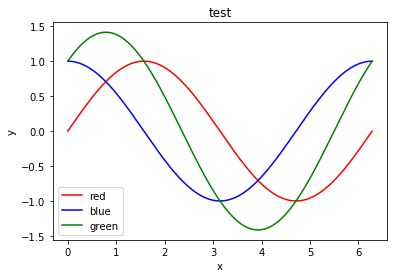

In [779]:
from numpy import *
import math
import matplotlib.pyplot as plt

t = linspace(0, 2*math.pi, 400)
a = sin(t)
b = cos(t)
c = a + b

plt.plot(t, a, 'r', label = "red") # plotting t, a separately 
plt.plot(t, b, 'b', label = "blue") # plotting t, b separately 
plt.plot(t, c, 'g', label = "green") # plotting t, c separately 
plt.title("test")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

In [461]:
from gurobipy import *
import numpy as np

'''
FAILED VERSION OF MODEL 2
The gardener now decides she wants to maximize the sum of the heights of the stem and flower.
She adds whether to plant the tulip outside (d = 1) in a flower bed to her list of considerations.
* Note: planting the tulip outside always adds 1 to the std dev of any distribution 
  since the outdoors present more variability 
      (i.e flower can be eaten by an animal, or thrive because of rich soil etc.)
Additionally, she considers the positive proportional relationship between total leaf surface area (lsa) 
and stem height:
    Stem Height ~ N(0.1*lsa, 0.01*lsa)
Each tulip type's leaf surface area and flower height are normally distributed and are affected by amount
of water and whether or not the plant is outside or not. 
    lsa ~ N(140*t + 150*(1 - t) - 0.05*x + 5*d - 5*(1 - d), 75*t + 33*(1 - t) + d) (if x <= 500)
    lsa ~ N(150*t + 140*(1 - t) + 0.01*x + 5*d - 5*(1 - d), 75*t + 33*(1 - t) + d) (if x >= 500.001)
        - If t = 1, total leaf SA usually ranges from 80-220cm^2 
        - If t = 0, total leaf SA usually ranges from 120-185cm^2 
        - More water increases lsa because there is more water available for photosynthesis 
         (photosynthesis occurs in the leaves)
        - Being planted outdoors increases lsa because there is more competition which causes 
         the plant to direct more growth to the leaf to be able to get more sunlight       
    Flower Height ~ N(3.35*t + 2.75*(1 - t) - 0.0015*x - 0.75*d + 0.75*(1 - d), 1.35*t + 0.75*(1 - t) + d) 
                        (if x >= 500.001)
                  ~ N(3.35*t + 2.75*(1 - t) + 0.002*x - 0.75*d + 0.75*(1 - d), 1.35*t + 0.75*(1 - t) + d)
                        (if x <= 500)
        - If t = 1, petal height is usually 2-4.7cm 
        - If t = 0, petal height is usually 2-3.5cm 
        - In drought conditions, plants direct more growth to their reproductive organ (flower)
          than leaf growth because larger lsa increases water loss and to ensure the species remains
          in the area (via reproduction) should it die during a drought. Simulate drought conditions 
          (less water) to induce flower growth
        - Being indoors increases flower height because there is less competition so the plant doesn't
          have to direct most growth to leaf surface area
'''
# Create model 
model2 = Model("Model #2")
model2.setParam('OutputFlag', 0)

# Create Variables 
t = model2.addVar(vtype = GRB.BINARY, name = "Tulip Type")
x = model2.addVar(lb = 250, ub = 1000, name = "Amount of Water/week (mL)")
d = model2.addVar(vtype = GRB.BINARY, name = "Outdoor?")
lsaavg = model2.addVar(name = "Total Leaf Surface Area Average")
lsastdev = model2.addVar(name = "Total Leaf Surface Area Standard Deviation")
lsa = model2.addVar(name = "Total Leaf Surface Area")
flavg = model2.addVar(name = "Flower Petal Height Average")
flstdev = model2.addVar(name = "Flower Petal Height Standard Deviation")
b = model2.addVar(vtype = GRB.BINARY, name = "Amount of Water Binary")

# Monte Carlo-ing Expectation
n = 100
i = 0
# Store sample averages for testing 
lavg = 0
savg = 0
favg = 0
leaf = LinExpr()
stem = LinExpr()
flower = LinExpr()
while i < n:
    lnorm = np.random.standard_normal()
    snorm = np.random.standard_normal()
    fnorm = np.random.standard_normal()
    
    leaf += lsaavg + lsastdev*lnorm
    stem += 0.1*(lsa) + 0.01*(lsa)*snorm
    flower += flavg + flstdev*fnorm 
    
    lavg += lnorm
    savg += snorm 
    favg += fnorm
    
    i += 1

lavg = (1/n)*lavg
savg = (1/n)*savg
favg = (1/n)*favg

print("Leaf standard normal sample average: " + str(lavg))
print("Stem standard normal sample average: " + str(savg))
print("Flower standard normal sample average: " + str(favg) + "\n")

# Set objective
model2.setObjective((1/n)*(stem + flower), GRB.MAXIMIZE)

# Set constraints 
M = 100000

# Amount of Water Constraints 
model2.addConstr(x <= 500 + M*(1 - b))
model2.addConstr(x >= 500.001 - M*b)

# Leaf Constraints
# If x <= 500, lsaavg = 155*t + 150*(1 - t) - 0.05*x + 5*d - 5*(1 - d), 
# else lsaavg = 155*t + 150*(1 - t) + 0.01*x + 5*d - 5*(1 - d)
model2.addConstr(lsaavg <= 140*t + 150*(1 - t) - 0.05*x + 5*d - 5*(1 - d) + M*(1 - b))
model2.addConstr(lsaavg >= 140*t + 150*(1 - t) - 0.05*x + 5*d - 5*(1 - d) - M*(1 - b))
model2.addConstr(lsaavg <= 150*t + 140*(1 - t) + 0.0001*x + 5*d - 5*(1 - d) + M*b)
model2.addConstr(lsaavg >= 150*t + 140*(1 - t) + 0.0001*x + 5*d - 5*(1 - d) - M*b)
# Setting lsastdev =75*t + 33*(1 - t) + d
model2.addConstr(lsastdev <= 75*t + 33*(1 - t) + d)
model2.addConstr(lsastdev >=  75*t + 33*(1 - t) + d)
# Setting lsa = leaf expression 
model2.addConstr(lsa <= (1/n)*leaf)
model2.addConstr(lsa >= (1/n)*leaf)

# Flower Constraints 
# If x <= 500, flavg = 3.35*t + 2.75*(1 - t) + 0.0015*x - 0.5*d + 0.5*(1 - t),
# else flavg = 3.35*t + 2.75*(1 - t) - 0.001*x - 0.5*d + 0.5*(1 - d)
model2.addConstr(flavg <= 3.35*t + 2.75*(1 - t) + 0.002*x - 0.75*d + 0.75*(1 - d) + M*(1 - b))
model2.addConstr(flavg >= 3.35*t + 2.75*(1 - t) + 0.002*x - 0.75*d + 0.75*(1 - d) - M*(1 - b))
model2.addConstr(flavg <= 3.35*t + 2.75*(1 - t) - 0.0015*x - 0.75*d + 0.75*(1 - d) + M*b)
model2.addConstr(flavg >= 3.35*t + 2.75*(1 - t) - 0.0015*x - 0.75*d + 0.75*(1 - d) - M*b)
# Setting flstdev = 1.35*t + 0.75*(1 - t) + d
model2.addConstr(flstdev <= 1.35*t + 0.75*(1 - t) + d)
model2.addConstr(flstdev >= 1.35*t + 0.75*(1 - t) + d)

model2.update()
# Optimize model
model2.optimize()

# Print and check results
if x.x <= 500:
    checkLA = 150*t.x + 150*(1 - t.x) - 0.05*x.x + 5*d.x - 5*(1 - d.x)
    checkFA = 3.35*t.x + 2.75*(1 - t.x) + 0.0015*x.x + 0.5*d.x + 0.5*(1 - d.x)
else:
    checkLA = 155*t.x + 150*(1 - t.x) + 0.01*x.x + 5*d.x - 5*(1 - d.x)
    checkFA = 3.35*t.x + 2.75*(1 - t.x) - 0.001*x.x - 0.5*d.x + 0.5*(1 - d.x)
checkLSD = 75*t.x + 33*(1 - t.x) + d.x
checkFSD = 1.35*t.x + 0.75*(1 - t.x) + d.x
checkLeafSA = checkLA + checkLSD*lavg

for v in model2.getVars():
    print('Gurobi Result: %s: %g' % (v.varName, v.x))
    if v.varName == "Total Leaf Surface Area Average":
        print('\tCheck Result: ' + str(checkLA))
    elif v.varName == 'Total Leaf Surface Area Standard Deviation':
        print('\tCheck Result: ' + str(checkLSD))
    elif v.varName == 'Total Leaf Surface Area':
        print('\tCheck Result: ' + str(checkLeafSA))
    elif v.varName == 'Flower Petal Height Average':
        print('\tCheck Result: ' + str(checkFA))
    elif v.varName == 'Flower Petal Height Standard Deviation':
        print('\tCheck Result: ' + str(checkFSD))


print('\nGurobi Stem + Flower Height (obj): %g' % model2.objVal)
print('\tCheck Stem Height: ' + str(0.1*checkLeafSA + 0.01*checkLeafSA*savg))
print('\tCheck Flower Height: ' + str(checkFA + checkFSD*favg))
print('\tCheck Total Height (obj): ' + str(0.1*checkLeafSA + 0.01*checkLeafSA*savg + checkFA + checkFSD*favg))

Leaf standard normal sample average: -0.14155125588128153
Stem standard normal sample average: 0.010166472389870172
Flower standard normal sample average: -0.032221399956186836

Gurobi Result: Tulip Type: 0
Gurobi Result: Amount of Water/week (mL): 250
Gurobi Result: Outdoor?: -0
Gurobi Result: Total Leaf Surface Area Average: 132.5
	Check Result: 132.5
Gurobi Result: Total Leaf Surface Area Standard Deviation: 33
	Check Result: 33.0
Gurobi Result: Total Leaf Surface Area: 127.829
	Check Result: 127.8288085559177
Gurobi Result: Flower Petal Height Average: 4
	Check Result: 3.625
Gurobi Result: Flower Petal Height Standard Deviation: 0.75
	Check Result: 0.75
Gurobi Result: Amount of Water Binary: 1

Gurobi Stem + Flower Height (obj): 16.7717
	Check Stem Height: 12.795876536119907
	Check Flower Height: 3.6008339500328597
	Check Total Height (obj): 16.396710486152767


In [294]:
from gurobipy import *
import numpy as np

'''
FAILED VERSION OF MODEL 3
Finally, the gardener decides she wants to maximize the sum of the heights of the stem and the flower 
as well as the length of the roots.
Since she is now taking the roots into consideration, she must also decide how many pellets (p) of
fertilizer to put into the soil/month (2 <= p <= 5).
The addition of fertilizer affects the leaf surface area (lsa) distribution:
    lsa ~ N(155*t + 150*(1 - t) - 0.05*x + 5*d - 5*(1 - d) -10*p , 75*t + 33*(1 - t) + d)
            (if x <= 500)
    lsa ~ N(155*t + 150*(1 - t) + 0.01*x + 5*d - 5*(1 - d) - 10*p, 75*t + 33*(1 - t) + d)
            (if x >= 500.001)
       - The addition of too much fertilizer causes the edges of the leaves to shrivel due to
         a phenomenon called "fertilizer burn", where the water sent from the roots to the 
         leaves is oversaturated with nutrients which causes the leaf tissues to dry
       - To ensure the plant does not completely dry up, we must add a constraint that we must add at
         least 150*p mL of water 
The root length (cm) is normally distributed:
    Root length ~ N(20 + p + 2*d , 1 + d)
        - Planting the tulip outside can increase the root length because of there is more space available
          and more nutrients at deeper altitudes. 
The stem and flower distributions remain the same. 
'''

# Create Model
model3 = Model("Model #3")
model3.setParam('OutputFlag', 0)

# Create Variables 
t = model3.addVar(vtype = GRB.BINARY, name = "Tulip Type")
x = model3.addVar(lb = 250, ub = 1000, name = "Amount of Water/week (mL)")
d = model3.addVar(vtype = GRB.BINARY, name = "Outdoor?")
p = model3.addVar(lb = 2, ub = 5, name = "Number of Fertilizer Pellets")
lsaavg = model3.addVar(name = "Total Leaf Surface Area Average")
lsastdev = model3.addVar(name = "Total Leaf Surface Area Standard Deviation")
lsa = model3.addVar(name = "Total Leaf Surface Area")
flavg = model3.addVar(name = "Flower Petal Height Average")
flstdev = model3.addVar(name = "Flower Petal Height Standard Deviation")
b = model3.addVar(vtype = GRB.BINARY, name = "Amount of Water Binary")

# Monte Carlo-ing Expectation
n = 100
i = 0
lavg = 0
savg = 0
favg = 0
ravg = 0
leaf = LinExpr()
stem = LinExpr()
flower = LinExpr()
roots = LinExpr()
while i < n:
    lnorm = np.random.standard_normal()
    snorm = np.random.standard_normal()
    fnorm = np.random.standard_normal()
    rnorm = np.random.standard_normal()
    
    leaf += lsaavg + lsastdev*lnorm
    stem += 0.1*(lsa) + 0.01*(lsa)*snorm
    flower += flavg + flstdev*fnorm 
    roots += 20 + p + 2*d + (1 + d)*rnorm
    
    lavg += lnorm
    savg += snorm 
    favg += fnorm
    ravg += rnorm
    
    i += 1

lavg = (1/n)*lavg
savg = (1/n)*savg
favg = (1/n)*favg
ravg = (1/n)*ravg

print("Leaf standard normal sample average: " + str(lavg))
print("Stem standard normal sample average: " + str(savg))
print("Flower standard normal sample average: " + str(favg))
print("Roots standard normal sample average: " + str(ravg) + "\n")

# Set objective
model3.setObjective((1/n)*(stem + flower + roots), GRB.MAXIMIZE)

# Set constraints 
M = 10000

# Amount of Water Constraints 
model3.addConstr(x <= 500 + M*(1 - b))
model3.addConstr(x >= 500.001 + M*b)

# Leaf Constraints
# If x <= 500, lsaavg = 155*t + 150*(1 - t) - 0.05*x + 5*d - 5*(1 - d) - 10*p, 
# else lsaavg = 155*t + 150*(1 - t) + 0.01*x + 5*d - 5*(1 - d) - 10*p
model3.addConstr(lsaavg <= 155*t + 150*(1 - t) - 0.05*x + 5*d - 5*(1 - d) - 10*p + M*(1 - b))
model3.addConstr(lsaavg >= 155*t + 150*(1 - t) - 0.05*x + 5*d - 5*(1 - d) - 10*p - M*(1 - b))
model3.addConstr(lsaavg <= 155*t + 150*(1 - t) + 0.01*x + 5*d - 5*(1 - d) - 10*p + M*b)
model3.addConstr(lsaavg >= 155*t + 150*(1 - t) + 0.01*x + 5*d - 5*(1 - d) - 10*p - M*b)
# Setting lsastdev =75*t + 33*(1 - t) + d
model3.addConstr(lsastdev <= 75*t + 33*(1 - t) + d)
model3.addConstr(lsastdev >=  75*t + 33*(1 - t) + d)
# Setting lsa = leaf expression 
model3.addConstr(lsa <= (1/n)*leaf)
model3.addConstr(lsa >= (1/n)*leaf)

# Flower Constraints 
# If x <= 500, flavg = 3.35*t + 2.75*(1 - t) + 0.0015*x - 0.5*d + 0.5*(1 - t),
# else flavg = 3.35*t + 2.75*(1 - t) - 0.001*x - 0.5*d + 0.5*(1 - t)
model3.addConstr(flavg <= 3.35*t + 2.75*(1 - t) + 0.0015*x - 0.5*d + 0.5*(1 - d) + M*(1 - b))
model3.addConstr(flavg >= 3.35*t + 2.75*(1 - t) + 0.0015*x - 0.5*d + 0.5*(1 - d) - M*(1 - b))
model3.addConstr(flavg <= 3.35*t + 2.75*(1 - t) - 0.001*x - 0.5*d + 0.5*(1 - d) + M*b)
model3.addConstr(flavg >= 3.35*t + 2.75*(1 - t) - 0.001*x - 0.5*d + 0.5*(1 - d) - M*b)
# Setting flstdev = 1.35*t + 0.75*(1 - t) + d
model3.addConstr(flstdev <= 1.35*t + 0.75*(1 - t) + d)
model3.addConstr(flstdev >= 1.35*t + 0.75*(1 - t) + d)

# Water vs. pellets constraint
model3.addConstr(x >= 150*p)

# Optimize model
model3.optimize()

# Print and check results
if x.x <= 500:
    checkLA = 155*t.x + 150*(1 - t.x) - 0.05*x.x + 5*d.x - 5*(1 - d.x) - 10*p.x
    checkFA = 3.35*t.x + 2.75*(1 - t.x) + 0.0015*x.x + 0.5*d.x + 0.5*(1 - d.x) 
else:
    checkLA = 155*t.x + 150*(1 - t.x) + 0.01*x.x + 5*d.x - 5*(1 - d.x) - 10*p.x
    checkFA = 3.35*t.x + 2.75*(1 - t.x) - 0.001*x.x - 0.5*d.x + 0.5*(1 - d.x)
checkLSD = 75*t.x + 33*(1 - t.x) + d.x
checkFSD = 1.35*t.x + 0.75*(1 - t.x) + d.x
checkLeafSA = checkLA + checkLSD*lavg
checkRoots = 20 + p.x + 2*d.x + (1 + d.x)*ravg

for v in model3.getVars():
    print('Gurobi Result: %s: %g' % (v.varName, v.x))
    if v.varName == "Total Leaf Surface Area Average":
        print('\tCheck Result: ' + str(checkLA))
    elif v.varName == 'Total Leaf Surface Area Standard Deviation':
        print('\tCheck Result: ' + str(checkLSD))
    elif v.varName == 'Total Leaf Surface Area':
        print('\tCheck Result: ' + str(checkLeafSA))
    elif v.varName == 'Flower Petal Height Average':
        print('\tCheck Result: ' + str(checkFA))
    elif v.varName == 'Flower Petal Height Standard Deviation':
        print('\tCheck Result: ' + str(checkFSD))


print('\nGurobi Stem + Flower + Roots Height (obj): %g' % model3.objVal)
print('\tCheck Stem Height: ' + str(0.1*checkLeafSA + 0.01*checkLeafSA*savg))
print('\tCheck Flower Height: ' + str(checkFA + checkFSD*favg))
print('\tCheck Roots Length: ' + str(checkRoots))
print('\tCheck Total Height (obj): ' + str(0.1*checkLeafSA + 0.01*checkLeafSA*savg + checkFA + checkFSD*favg + checkRoots))

Leaf standard normal sample average: -0.18215036842883778
Stem standard normal sample average: 0.022661373486950707
Flower standard normal sample average: 0.25453779630726225
Roots standard normal sample average: -0.020773096492568106

Gurobi Result: Tulip Type: 0
Gurobi Result: Amount of Water/week (mL): 1000
Gurobi Result: Outdoor?: 1
Gurobi Result: Number of Fertilizer Pellets: 2
Gurobi Result: Total Leaf Surface Area Average: 145
	Check Result: 145.0
Gurobi Result: Total Leaf Surface Area Standard Deviation: 34
	Check Result: 34.0
Gurobi Result: Total Leaf Surface Area: 138.807
	Check Result: 138.80688747341952
Gurobi Result: Flower Petal Height Average: 1.75
	Check Result: 1.75
Gurobi Result: Flower Petal Height Standard Deviation: 1.75
	Check Result: 1.75
Gurobi Result: Amount of Water Binary: 0

Gurobi Stem + Flower + Roots Height (obj): 40.066
	Check Stem Height: 13.912144294537915
	Check Flower Height: 2.195441143537709
	Check Roots Length: 23.958453807014862
	Check Total Heig

In [80]:
from gurobipy import *
import numpy as np

# Create Model
modelx = Model("Modelx")
#modelx.setParam('OutputFlag', 0)

# Create variables
x1 = modelx.addVar(lb = -1000, ub= 1000, name = "x1")
x2 = modelx.addVar(vtype = GRB.BINARY, name = "x2")
sca1 = modelx.addVar(lb = -1*GRB.INFINITY, ub = GRB.INFINITY, name = "y1 scale")
loc2 = modelx.addVar(lb = -1*GRB.INFINITY, ub = GRB.INFINITY, name = "y2 location")

# Monte carlo
n = 10 # Number of trials 
e1 = 0
e2 = 0
i = 0
y1 = LinExpr()
y2 = LinExpr()
while i < n:
    norm1 = np.random.standard_normal()
    norm2 = np.random.standard_normal()
    y1 += x1 + sca1*norm1
    y2 += loc2 + x1*norm2
    e1 += norm1 # Used to check the sample average for testing
    e2 += norm2
    i += 1
e1 = e1/n
e2 = e2/n
print("Sample average of e1 is: " + str(e1))
print("Sample average of e2 is: " + str(e2) + "\n")

#Set objective 
modelx.setObjective((1/n)*(y1 - y2), GRB.MAXIMIZE)

#Set constraints
M = 10000

#y1 constraints 
modelx.addConstr(sca1 <= -2*x1 + M*(1 - x2))
modelx.addConstr(sca1 >= -2*x1 - M*(1 - x2))
modelx.addConstr(sca1 <= 2*x1 + M*x2)
modelx.addConstr(sca1 >= 2*x1 - M*x2)

#y2 constraints
modelx.addConstr(loc2 <= 1.5*x1 + M*(1 - x2))
modelx.addConstr(loc2 >= 1.5*x1 - M*(1 - x2))
modelx.addConstr(loc2 <= 2*x1 + M*x2)
modelx.addConstr(loc2 >= 2*x1 - M*x2)

# Optimize model
modelx.optimize()

# Print Results 
for v in modelx.getVars():
    print('%s: %g' % (v.varName, v.x))

print('Obj: %g' % modelx.objVal)

Sample average of e1 is: 0.05557326916084613
Sample average of e2 is: -0.3345019890237368

Optimize a model with 8 rows, 4 columns and 24 nonzeros
Variable types: 3 continuous, 1 integer (1 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [6e-02, 1e+00]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+04, 1e+04]
Presolve time: 0.00s
Presolved: 8 rows, 4 columns, 24 nonzeros
Variable types: 3 continuous, 1 integer (1 binary)

Root relaxation: objective 1.902357e+03, 3 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1902.35702    0    1          - 1902.35702      -     -    0s
H    0     0                     554.3514727 1902.35702   243%     -    0s

Cutting planes:
  MIR: 1

Explored 0 nodes (3 simplex iterations) in 0.02 seconds
Thread count was 4 (of 4 available processors)

Solution count 1: 554.351 

In [74]:
from gurobipy import *
import numpy as np

# Create Model
modely = Model("Modely")
#model3.setParam('OutputFlag', 0)

# Create variables
loc = modely.addVar(lb = -1*GRB.INFINITY, ub = GRB.INFINITY, name = "Location")
d = modely.addVar(vtype = GRB.BINARY, name = "Difficult")
m = modely.addVar(vtype = GRB.BINARY, name = "Multiple Choice")
x = modely.addVar(lb = 60, ub = 120, name = "Time")

#Set coefficient e -> Monte carlo'd over n trials 
n = 10000 # Number of trials 
e1 = 0
e2 = 0
i = 0
y = LinExpr()
bonus = LinExpr()
while i < n:
    norm1 = np.random.standard_normal()
    norm2 = np.random.standard_normal()
    y += loc + (10*d + 5*m)*norm1
    bonus += d + norm2
    e1 += norm1 # Used to check the sample average for testing
    e2 += norm2
    i += 1
e1 = e1/n
e2 = e2/n
print("Sample average of e1 is: " + str(e1))
print("Sample average of e2 is: " + str(e2) + "\n")

#Set objective 
modely.setObjective((1/n)*y + (1/n)*bonus, GRB.MAXIMIZE)

#Set constraints
M = 10000

#y constraints 
modely.addConstr(loc <= 60 - 5*m + 0.1*x + M*(1 - d))
modely.addConstr(loc >= 60 - 5*m + 0.1*x - M*(1 - d))
modely.addConstr(loc <= 70 + 3*m + 0.001*x + M*d)
modely.addConstr(loc >= 70 + 3*m + 0.001*x - M*d)

# Optimize model
modely.optimize()

# Print Results 
for v in modely.getVars():
    print('%s: %g' % (v.varName, v.x))

print('Obj: %g' % modely.objVal)

Sample average of e1 is: 0.01885855880991378
Sample average of e2 is: 0.0060704045082175355

Optimize a model with 4 rows, 4 columns and 16 nonzeros
Variable types: 2 continuous, 2 integer (2 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+04]
  Objective range  [9e-02, 1e+00]
  Bounds range     [1e+00, 1e+02]
  RHS range        [7e+01, 1e+04]
Presolve time: 0.00s
Presolved: 4 rows, 4 columns, 16 nonzeros
Variable types: 2 continuous, 2 integer (2 binary)

Root relaxation: objective 7.398169e+01, 2 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   73.98169    0    2          -   73.98169      -     -    0s
H    0     0                      68.2889488   73.98169  8.34%     -    0s
H    0     0                      73.1946560   73.98169  1.08%     -    0s
H    0     0                      73.2203632   73.98169  1.04%     -    0s

Expl

In [76]:
from gurobipy import *
import numpy as np

# Create Model
modelz = Model("Modelz")
#modelz.setParam('OutputFlag', 0)

# Create variables
x1 = modelz.addVar(lb = 1, ub = 10, vtype = GRB.INTEGER, name = "x1")
x2 = modelz.addVar(lb = -1*GRB.INFINITY, ub = GRB.INFINITY, name = "x2")
x3 = modelz.addVar(lb = -1*GRB.INFINITY, ub = GRB.INFINITY, name = "x3")
b3 = modelz.addVar(vtype = GRB.BINARY, name = "b3")
x4 = modelz.addVar(lb = -1*GRB.INFINITY, ub = GRB.INFINITY, name = "x4")
b4 = modelz.addVar(vtype = GRB.BINARY, name = "b4")
y2loc = modelz.addVar(lb = -1*GRB.INFINITY, ub = GRB.INFINITY, name = "y2loc")
by2 = modelz.addVar(vtype = GRB.BINARY, name = "by2")

#Set coefficient e -> Monte carlo'd over n trials 
n = 10000 # Number of trials 
x2e = 0
y1e = 0
y2e = 0
y3e = 0
i = 0
x2expr = LinExpr()
y1 = LinExpr()
y2 = LinExpr()
y3 = LinExpr()
bonus = LinExpr()
while i < n:
    normx = np.random.standard_normal()
    norm1 = np.random.standard_normal()
    norm2 = np.random.standard_normal()
    norm3 = np.random.standard_normal()
    
    x2expr += x1*normx
    y1 += (x3 - x4) + (x3 + x4)*norm1
    y2 += y2loc + (x4 - x3)*norm2
    y3 += x4*norm3
    
    x2e += normx
    y1e += norm1
    y2e += norm2
    y3e += norm3

    i += 1

print("Sample average of x2e is: " + str(x2e/n))
print("Sample average of y1e is: " + str(y1e/n))
print("Sample average of y2e is: " + str(y2e/n))
print("Sample average of y3e is: " + str(y3e/n) + "\n")

#Set objective 
modelz.setObjective((1/n)*(y1 - y2 + y3), GRB.MAXIMIZE)

#Set constraints
M = 10000

# x2 constraint
modelz.addConstr(x2 == (1/n)*x2expr)

# x3 constraints 
modelz.addConstr(x2 >= x1 - M*b3)
modelz.addConstr(x3 >= x2 - x1 - M*b3)
modelz.addConstr(x3 <= x2 - x1 + M*b3)
modelz.addConstr(x2 <= x1 + M*(1 - b3))
modelz.addConstr(x3 >= (1/2)*x1 - x2 - M*(1 - b3))
modelz.addConstr(x3 <= (1/2)*x1 - x2 + M*(1 - b3))

# x4 constraints 
modelz.addConstr(x2 <= -1*x1 + M*b4)
modelz.addConstr(x4 >= -1*x1 - x2 - M*b4)
modelz.addConstr(x4 <= -1*x1 - x2 + M*b4)
modelz.addConstr(x2 >= -1*x1 - M*(1 - b4))
modelz.addConstr(x4 >= 2*x2 - M*(1 - b4))
modelz.addConstr(x4 <= 2*x2 + M*(1 - b4))

# y2loc constraints 
modelz.addConstr(x3 >= x4 - M*by2)
modelz.addConstr(y2loc >= x4 - M*by2)
modelz.addConstr(y2loc <= x4 + M*by2)
modelz.addConstr(x3 <= x4 + M*(1 - by2))
modelz.addConstr(y2loc >= x3 - M*(1 - by2))
modelz.addConstr(y2loc <= x3 + M*(1 - by2))

# Optimize model
modelz.optimize()

# Print Results 
for v in modelz.getVars():
    print('%s: %g' % (v.varName, v.x))

print('Obj: %g' % modelz.objVal)

Sample average of x2e is: 0.009540473404689742
Sample average of y1e is: 0.0076242765638888715
Sample average of y2e is: 0.008624923623610609
Sample average of y3e is: -0.002560717290279621

Optimize a model with 19 rows, 8 columns and 62 nonzeros
Variable types: 4 continuous, 4 integer (3 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+04, 1e+04]
Presolve removed 19 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 4 available processors)

Solution count 1: 4.60199 
Pool objective bound 4.60199

Optimal solution found (tolerance 1.00e-04)
Best objective 4.601992538043e+00, best bound 4.601992538043e+00, gap 0.0000%
x1: 10
x2: 0.0954047
x3: 4.9046
b3: 1
x4: 0.190809
b4: 1
y2loc: 0.190809
by2: 0
Obj: 4.60199
